In [29]:
import pandas as pd

# Carga del dataset

df = pd.read_csv('C:/Users/WINDOWS/Desktop/Bootcamp_IA/Hospital_F5/DS_Grupo3/src/datasets/train_stroke_woe.csv')

# Mostrar primeras filas
df.head()

,gender,hypertension,heart_disease,ever_married,work_type,Residence_type,smoking_status,stroke,bmi_category,age_category,glucose_level_category
0,0,0,0,0,0.059265,1,-0.249627,0,-0.543404,-3.922206,0.921024
1,0,0,0,1,0.059265,1,0.062398,0,0.176297,-3.922206,-0.301429
2,1,0,0,1,0.033575,0,0.062398,1,0.176297,-0.367003,-0.301429
3,0,0,0,0,-2.952380,0,-0.249627,0,-2.816305,-3.068490,-0.301429
4,0,1,0,1,0.059265,0,0.559182,0,0.176297,1.069885,-0.301429


Dividir datos en entrenamiento y prueba.

In [30]:
from sklearn.model_selection import train_test_split

# Dividir en características (X) y la variable objetivo (y)
X = df.drop('stroke', axis=1)
y = df['stroke']

In [31]:
import optuna
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score, make_scorer
from sklearn.model_selection import KFold, cross_val_score

# Dividir los datos
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)



def objective(trial):
    # Definir el espacio de búsqueda
    n_estimators = trial.suggest_int('n_estimators', 50, 300)
    max_depth = trial.suggest_int('max_depth', 3, 30)
    min_samples_split = trial.suggest_int('min_samples_split', 2, 10)
    min_samples_leaf = trial.suggest_int('min_samples_leaf', 1, 4)

    # Crear el modelo
    model = RandomForestClassifier(n_estimators=n_estimators,
                                   max_depth=max_depth,
                                   min_samples_split=min_samples_split,
                                   min_samples_leaf=min_samples_leaf,
                                   random_state=42)

    # Definir la validación cruzada (KFold)
    kf = KFold(n_splits=5, shuffle=True, random_state=42)

    # Usar cross_val_score para evaluar con K-Fold. Aquí usamos f1_score.
    # make_scorer(f1_score) se usa para asegurarnos de calcular el f1_score.
    scores = cross_val_score(model, X_train, y_train, cv=kf, scoring=make_scorer(f1_score))

    # Retornar la media de los scores de validación cruzada
    return scores.mean()



# Crear un estudio y optimizarlo
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=100)

# Verificar si el estudio ha encontrado los mejores parámetros
if study.best_params:
    # Obtener los mejores hiperparámetros
    best_params = study.best_params
    print("Best parameters:", best_params)
else:
    raise ValueError("No best parameters found. The optimization may have failed.")


[I 2024-10-11 09:57:31,082] A new study created in memory with name: no-name-8df224bb-b895-4677-a10c-b1e40b3938f0
[I 2024-10-11 09:57:32,007] Trial 0 finished with value: 0.0 and parameters: {'n_estimators': 139, 'max_depth': 23, 'min_samples_split': 2, 'min_samples_leaf': 3}. Best is trial 0 with value: 0.0.
[I 2024-10-11 09:57:32,437] Trial 1 finished with value: 0.0 and parameters: {'n_estimators': 63, 'max_depth': 28, 'min_samples_split': 7, 'min_samples_leaf': 3}. Best is trial 0 with value: 0.0.
[I 2024-10-11 09:57:33,510] Trial 2 finished with value: 0.0 and parameters: {'n_estimators': 174, 'max_depth': 7, 'min_samples_split': 4, 'min_samples_leaf': 3}. Best is trial 0 with value: 0.0.
[I 2024-10-11 09:57:35,457] Trial 3 finished with value: 0.011428571428571429 and parameters: {'n_estimators': 281, 'max_depth': 18, 'min_samples_split': 5, 'min_samples_leaf': 1}. Best is trial 3 with value: 0.011428571428571429.
[I 2024-10-11 09:57:35,792] Trial 4 finished with value: 0.0 and p

Best parameters: {'n_estimators': 225, 'max_depth': 12, 'min_samples_split': 2, 'min_samples_leaf': 1}


Preparación y entrenamiento del modelo (RandomForest)

In [32]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score, roc_auc_score

# Inicializar el modelo RandomForest con los mejores hiperparámetros obtenidos
rf_model = RandomForestClassifier(
    n_estimators=best_params['n_estimators'],
    max_depth=best_params['max_depth'],
    min_samples_split=best_params['min_samples_split'],
    min_samples_leaf=best_params['min_samples_leaf'],
    random_state=42
)

# Entrenar el modelo con los datos de entrenamiento
rf_model.fit(X_train, y_train)

# Hacer predicciones con los datos de prueba
y_pred = rf_model.predict(X_test)

# Evaluar el rendimiento del modelo final
print("Accuracy:", accuracy_score(y_test, y_pred))
print("ROC-AUC Score:", roc_auc_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

Accuracy: 0.9531772575250836
ROC-AUC Score: 0.5167510437887008
              precision    recall  f1-score   support

           0       0.97      0.99      0.98      1153
           1       0.12      0.05      0.07        43

    accuracy                           0.95      1196
   macro avg       0.54      0.52      0.52      1196
weighted avg       0.93      0.95      0.94      1196



Verificar si el modelo está balanceado

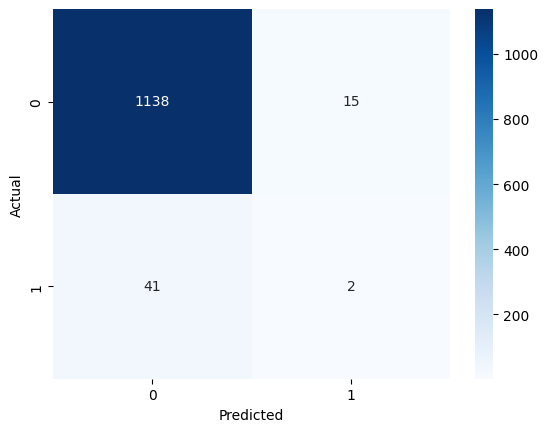

In [33]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Calcular la matriz de confusión
cm = confusion_matrix(y_test, y_pred)

# Mostrar la matriz de confusión
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

Análisis del Balance de Clases

In [34]:
# Contar la clase objetivo
print(df['stroke'].value_counts(normalize=True))

stroke
0    0.951305
1    0.048695
Name: proportion, dtype: float64


Este desbalance de clases tan significativo, influye negativamente en el rendimiento del modelo, por lo que vamos a tratarlo antes del entrenamiento. Utilizaremos la técnica de Oversampling. Esta técnica aumenta la cantidad de ejemplos en la clase minoritaria mediante la replicación de ejemplos existentes o la creación de ejemplos sintéticos, como lo hace SMOTE (Synthetic Minority Over-sampling Technique).

Balanceo de clases

In [35]:
from imblearn.over_sampling import SMOTE

# Aplicar SMOTE para el balanceo de clases
smote = SMOTE(random_state=42)
X_train_balanced, y_train_balanced = smote.fit_resample(X_train, y_train)

# Reentrenar el modelo con los datos balanceados
rf_model_balanced = RandomForestClassifier(random_state=42)
rf_model_balanced.fit(X_train_balanced, y_train_balanced)

# Hacer predicciones nuevamente
y_pred_balanced = rf_model_balanced.predict(X_test)

# Evaluar el modelo balanceado
print("Accuracy:", accuracy_score(y_test, y_pred_balanced))
print("ROC-AUC Score:", roc_auc_score(y_test, y_pred_balanced))
print(classification_report(y_test, y_pred_balanced))


Accuracy: 0.9264214046822743
ROC-AUC Score: 0.5140684564029125
              precision    recall  f1-score   support

           0       0.97      0.96      0.96      1153
           1       0.06      0.07      0.06        43

    accuracy                           0.93      1196
   macro avg       0.51      0.51      0.51      1196
weighted avg       0.93      0.93      0.93      1196



Probar con LightGBM

In [ ]:
import lightgbm as lgb
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import accuracy_score, roc_auc_score, classification_report
import numpy as np
import optuna

# Definir la función objetivo para Optuna
def objective(trial):
    # Sugerir hiperparámetros
    param = {
        'objective': 'binary',
        'metric': 'binary_logloss',
        'is_unbalance': True,  # Manejar el desbalance de clases
        'learning_rate': trial.suggest_loguniform('learning_rate', 1e-3, 1e-1),
        'num_leaves': trial.suggest_int('num_leaves', 20, 150),
        'min_data_in_leaf': trial.suggest_int('min_data_in_leaf', 20, 100),
        'feature_fraction': trial.suggest_uniform('feature_fraction', 0.4, 1.0),
        'bagging_fraction': trial.suggest_uniform('bagging_fraction', 0.4, 1.0),
        'bagging_freq': trial.suggest_int('bagging_freq', 1, 10),
        'min_sum_hessian_in_leaf': trial.suggest_float('min_sum_hessian_in_leaf', 1e-3, 10)
    }

    # Validación cruzada KFold
    kf = KFold(n_splits=5, shuffle=True, random_state=42)
    
    # Crear dataset para LightGBM
    lgb_train = lgb.Dataset(X_train_balanced, label=y_train_balanced)

    # Entrenar el modelo
    lgb_model = lgb.train(param, lgb_train, num_boost_round=100)

    # Predecir
    y_pred_lgb = lgb_model.predict(X_test)
    y_pred_lgb_binary = (y_pred_lgb > 0.5).astype(int)

    # Evaluar el F1-score (puedes cambiar esta métrica si deseas optimizar otra cosa)
    return roc_auc_score(y_test, y_pred_lgb_binary)

# Crear un estudio de Optuna y optimizarlo
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=100)

# Imprimir los mejores hiperparámetros
print("Best parameters:", study.best_params)

In [37]:
# Obtener los mejores parámetros
best_params = study.best_params

# Agregar otros parámetros necesarios
best_params.update({
    'objective': 'binary',
    'metric': 'binary_logloss',
    'is_unbalance': True  # Mantener el manejo del desbalance de clases
})

# Crear el dataset para LightGBM
lgb_train = lgb.Dataset(X_train_balanced, label=y_train_balanced)

# Entrenar el modelo con los mejores parámetros
lgb_model = lgb.train(best_params, lgb_train, num_boost_round=100)

# Hacer predicciones
y_pred_lgb = lgb_model.predict(X_test)
y_pred_lgb_binary = (y_pred_lgb > 0.5).astype(int)

# Evaluar el rendimiento del modelo
print("LightGBM Accuracy:", accuracy_score(y_test, y_pred_lgb_binary))
print("LightGBM ROC-AUC Score:", roc_auc_score(y_test, y_pred_lgb_binary))
print(classification_report(y_test, y_pred_lgb_binary))

[LightGBM] [Info] Number of positive: 2637, number of negative: 2637
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0,000594 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 972
[LightGBM] [Info] Number of data points in the train set: 5274, number of used features: 10
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0,500000 -> initscore=0,000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits w

Feature importances

In [38]:
# Obtener las importancias de las características
importances = lgb_model.feature_importance()
feature_names = X.columns

# Crear un DataFrame para visualizarlas
feature_importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': importances})
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

# Mostrar las características más importantes
print(feature_importance_df)

                  Feature  Importance
7            bmi_category         499
6          smoking_status         451
4               work_type         443
8            age_category         268
9  glucose_level_category          98
5          Residence_type          92
0                  gender          63
3            ever_married          33
1            hypertension          18
2           heart_disease           0


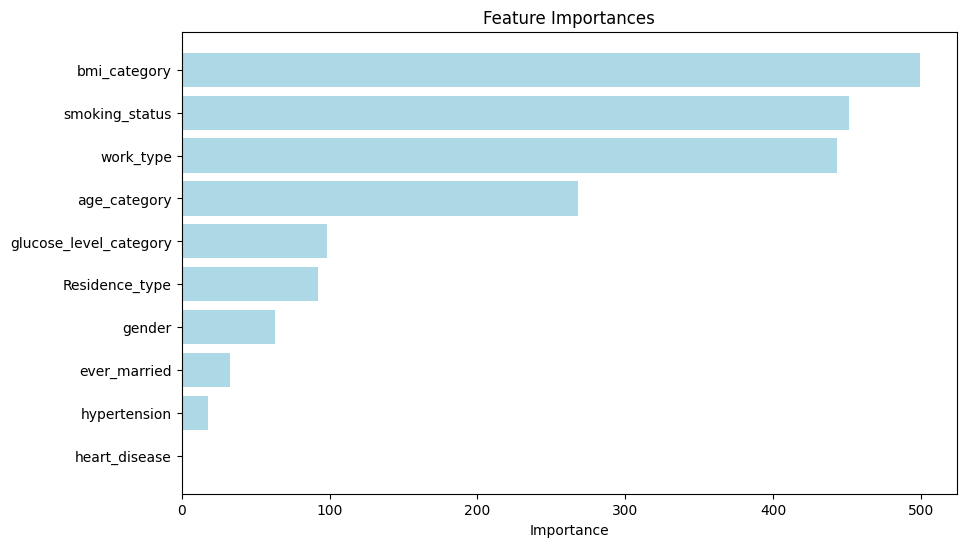

In [39]:
# Visualizar las importancias
plt.figure(figsize=(10, 6))
plt.barh(feature_importance_df['Feature'], feature_importance_df['Importance'], color='lightblue')
plt.xlabel('Importance')
plt.title('Feature Importances')
plt.gca().invert_yaxis()  # Invertir el eje y para que la característica más importante esté arriba
plt.show()